In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件

import warnings
warnings.filterwarnings('ignore')

#系統操作、解壓縮檔案
import os
from zipfile import ZipFile

#機器學習
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate

#統計
import scipy.stats as st

# 設定 data_path
dir_data = './data/'

In [2]:
#安裝geopandas有許多坑，很容易error，可以參考 https://zhuanlan.zhihu.com/p/137628480，文中第3個方法
#地理資料相關
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries

from shapely import geos, geometry
from shapely.geometry import shape,LineString,Point,Polygon

import fiona
from fiona.crs import from_epsg,from_string

#繪圖相關
import folium
from folium import IFrame

#顏色相關
import seaborn as sns
import branca

In [3]:
#安裝道路分析 相關套件
import osmnx as ox
import networkx as nx

In [4]:
# GIS編碼轉換
def trans(gdf):
    gdf.crs = {'init' :'epsg:3824'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs({'init' :'epsg:4326'})
    return gdf
# 中文顯示
def utf2asc(s):
    return str(str(s).encode('ascii', 'xmlcharrefreplace'))[2:-1]
heading3 = """<h3>{}</h3>""".format

In [5]:
f_path = os.path.join(dir_data, 'GIS/捷運_1100406/MRT_1100406.shp')
print('Path of read in data: %s' % (f_path))

gdf_mrt = gpd.read_file(f_path,encoding='utf-8')

Path of read in data: ./data/GIS/捷運_1100406/MRT_1100406.shp


In [6]:
gdf_mrt['MRTCODE'].unique()

array(['中和新蘆線', '文湖線', '板南線', '淡水信義線', '機場捷運', '松山新店線', None, '貓空纜車',
       '新北投線', '綠線', '紅線', '橘線', '環狀線', '三鶯線', '小碧潭線'], dtype=object)

In [7]:
f_path = os.path.join(dir_data, 'GIS/捷運_1100406/捷運站經緯度.xlsx')
print('Path of read in data: %s' % (f_path))
MRT = pd.read_excel(f_path)


MRT_sub=MRT[MRT['station_name_tw'].isin(['景美','大坪林','七張','新店區公所','新店','小碧潭','南勢角','景安','永安市場','頂溪'])].reset_index(drop=True)

Path of read in data: ./data/GIS/捷運_1100406/捷運站經緯度.xlsx


In [8]:
MRT_sub.head(3)

station_code construction_id station_name_tw          station_name_en  \
0          G01              G1              新店                  Xindian   
1          G02              G2           新店區公所  Xindian District Office   
2          G03              G3              七張                  Qizhang   

  line_code line_name          address        lat         lon    color  
0         G     松山新店線    新北市新店區北宜路一段2號  24.957855  121.537584  #008659  
1         G     松山新店線  新北市新店區北新路一段295號  24.967393  121.541310  #008659  
2         G     松山新店線  新北市新店區北新路二段150號  24.975169  121.542942  #008659

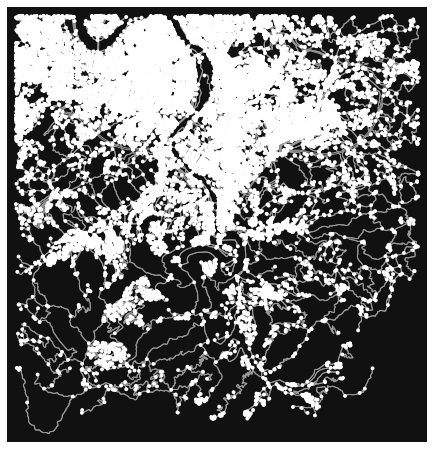

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [9]:
# https://geoffboeing.com/2016/11/osmnx-python-street-networks/
# drive, drive_service, walk, bike, all, all_private
site_lat = 24.956544
site_lon = 121.536432
G = ox.graph_from_point((site_lat, site_lon), dist=7000, network_type='all')
ox.plot_graph(G)

In [10]:
G = ox.project_graph(G) # 投影
gdf1,gdf2=ox.graph_to_gdfs(G)

meters_per_minute = 30 * 1000 / 60 # 每小時30公里
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [11]:
gdf1

y              x  street_count         lon        lat  \
osmid                                                                          
48061385    2.763101e+06  356164.625619             3  121.574979  24.976499   
48061476    2.763026e+06  354342.406936             3  121.556938  24.975649   
48075338    2.763054e+06  356169.468089             3  121.575032  24.976080   
48075583    2.762801e+06  353767.544644             3  121.551268  24.973558   
586762237   2.762546e+06  353789.351926             3  121.551511  24.971262   
...                  ...            ...           ...         ...        ...   
8596910608  2.755958e+06  348275.311074             1  121.497621  24.911248   
8596910612  2.756036e+06  348215.413298             1  121.497019  24.911939   
8596910614  2.756011e+06  348170.202310             1  121.496574  24.911715   
8616664923  2.765555e+06  354451.521822             3  121.557753  24.998488   
8616664927  2.765578e+06  354405.681611             3  121.557296  24.998696   

            ref            highway                        geometry  
osmid                                                               
48061385    NaN                NaN  POINT (356164.626 2763100.901)  
48061476     26  motorway_junction  POINT (354342.407 2763026.047)  
48075338    NaN                NaN  POINT (356169.468 2763054.419)  
48075583    NaN                NaN  POINT (353767.545 2762800.512)  
586762237   NaN                NaN  POINT (353789.352 2762546.021)  
...         ...                ...                             ...  
8596910608  NaN                NaN  POINT (348275.311 2755958.384)  
8596910612  NaN                NaN  POINT (348215.413 2756035.641)  
8596910614  NaN                NaN  POINT (348170.202 2756011.329)  
8616664923  NaN                NaN  POINT (354451.522 2765554.584)  
8616664927  NaN                NaN  POINT (354405.682 2765578.111)  

[25807 rows x 8 columns]

In [12]:
trip_times = [1, 2, 4] #分鐘
# 給定顏色
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)


for i in range(MRT_sub.shape[0]):
    if i == 0:
        if MRT_sub['station_name_tw'][i]=='小碧潭':
            center_node = 2216662234
        else:
            center_node=gdf1[(gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2==min((gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2)].index[0]#最近點
        print(1)

        node_colors = {}
        for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
            for node in subgraph.nodes():
                node_colors[node] = color # 抵達的node給顏色

        nc = [node_colors[node] if node in node_colors else 'blue' for node in G.nodes()]
        gdf1['color']=nc

        gdf_sub0=gdf1.loc[gdf1.color.isin(iso_colors[0:3]),:]
        gdf_sub1=gdf1.loc[gdf1.color.isin(iso_colors[1:3]),:]
        gdf_sub2=gdf1.loc[gdf1.color.isin(iso_colors[2:3]),:]

        sub_convex0=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub0.geometry.y))).convex_hull
        sub_convex1=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub1.geometry.y))).convex_hull
        sub_convex2=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub2.geometry.y))).convex_hull
        
        sub_convex0_base = gpd.GeoDataFrame({'geometry': sub_convex0, 'df':[0]})
        sub_convex1_base = gpd.GeoDataFrame({'geometry': sub_convex1, 'df':[1]})
        sub_convex2_base = gpd.GeoDataFrame({'geometry': sub_convex2, 'df':[2]})
        
    else:
        if MRT_sub['station_name_tw'][i]=='小碧潭':
            center_node = 2216662234
        else:
            center_node=gdf1[(gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2==min((gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2)].index[0]#最近點
        print(1)

        node_colors = {}
        for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
            for node in subgraph.nodes():
                node_colors[node] = color # 抵達的node給顏色

        nc = [node_colors[node] if node in node_colors else 'blue' for node in G.nodes()]
        gdf1['color']=nc

        gdf_sub0=gdf1.loc[gdf1.color.isin(iso_colors[0:3]),:]
        gdf_sub1=gdf1.loc[gdf1.color.isin(iso_colors[1:3]),:]
        gdf_sub2=gdf1.loc[gdf1.color.isin(iso_colors[2:3]),:]

        sub_convex0=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub0.geometry.y))).convex_hull
        sub_convex1=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub1.geometry.y))).convex_hull
        sub_convex2=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub2.geometry.y))).convex_hull
        
        sub_convex0 = gpd.GeoDataFrame({'geometry': sub_convex0, 'df':[0]})
        sub_convex1 = gpd.GeoDataFrame({'geometry': sub_convex1, 'df':[1]})
        sub_convex2 = gpd.GeoDataFrame({'geometry': sub_convex2, 'df':[2]})
    
        sub_convex0_base = gpd.overlay(sub_convex0_base,sub_convex0,  how='union')
        sub_convex1_base = gpd.overlay(sub_convex1_base,sub_convex1,  how='union')
        sub_convex2_base = gpd.overlay(sub_convex2_base,sub_convex2,  how='union')
        
        sub_convex0_base['df']=0
        sub_convex0_base = sub_convex0_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex1_base['df']=1
        sub_convex1_base = sub_convex1_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex2_base['df']=2
        sub_convex2_base = sub_convex2_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
    
    print(2)

sub_convex0_base = gpd.GeoDataFrame(sub_convex0_base,crs = gdf1.crs)
sub_convex1_base = gpd.GeoDataFrame(sub_convex1_base,crs = gdf1.crs)
sub_convex2_base = gpd.GeoDataFrame(sub_convex2_base,crs = gdf1.crs)

1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


In [13]:
'''
trip_times = [0.5, 1.0, 1.5, 2.0 ,2.5, 3.0, 3.5, 4.0 ,4.5] #分鐘
# 給定顏色
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)


for i in range(MRT_sub.shape[0]):
    if i == 0:
        if MRT_sub['station_name_tw'][i]=='小碧潭':
            center_node = 2216662234
        else:
            center_node=gdf1[(gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2==min((gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2)].index[0]#最近點
        print(1)

        node_colors = {}
        for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
            for node in subgraph.nodes():
                node_colors[node] = color # 抵達的node給顏色

        nc = [node_colors[node] if node in node_colors else 'blue' for node in G.nodes()]
        gdf1['color']=nc

        gdf_sub0=gdf1.loc[gdf1.color.isin(iso_colors[0:9]),:]
        gdf_sub1=gdf1.loc[gdf1.color.isin(iso_colors[1:9]),:]
        gdf_sub2=gdf1.loc[gdf1.color.isin(iso_colors[2:9]),:]
        gdf_sub3=gdf1.loc[gdf1.color.isin(iso_colors[3:9]),:]
        gdf_sub4=gdf1.loc[gdf1.color.isin(iso_colors[4:9]),:]
        gdf_sub5=gdf1.loc[gdf1.color.isin(iso_colors[5:9]),:]
        gdf_sub6=gdf1.loc[gdf1.color.isin(iso_colors[6:9]),:]
        gdf_sub7=gdf1.loc[gdf1.color.isin(iso_colors[7:9]),:]
        gdf_sub8=gdf1.loc[gdf1.color.isin(iso_colors[8:9]),:]

        sub_convex0=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub0.geometry.y))).convex_hull
        sub_convex1=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub1.geometry.y))).convex_hull
        sub_convex2=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub2.geometry.y))).convex_hull
        sub_convex3=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub3.geometry.y))).convex_hull
        sub_convex4=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub4.geometry.y))).convex_hull
        sub_convex5=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub5.geometry.y))).convex_hull
        sub_convex6=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub6.geometry.y))).convex_hull
        sub_convex7=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub7.geometry.y))).convex_hull
        sub_convex8=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub8.geometry.y))).convex_hull
        
        
        sub_convex0_base = gpd.GeoDataFrame({'geometry': sub_convex0, 'df':[0]})
        sub_convex1_base = gpd.GeoDataFrame({'geometry': sub_convex1, 'df':[1]})
        sub_convex2_base = gpd.GeoDataFrame({'geometry': sub_convex2, 'df':[2]})
        sub_convex3_base = gpd.GeoDataFrame({'geometry': sub_convex3, 'df':[3]})
        sub_convex4_base = gpd.GeoDataFrame({'geometry': sub_convex4, 'df':[4]})
        sub_convex5_base = gpd.GeoDataFrame({'geometry': sub_convex5, 'df':[5]})
        sub_convex6_base = gpd.GeoDataFrame({'geometry': sub_convex6, 'df':[6]})
        sub_convex7_base = gpd.GeoDataFrame({'geometry': sub_convex7, 'df':[7]})
        sub_convex8_base = gpd.GeoDataFrame({'geometry': sub_convex8, 'df':[8]})
        
    else:
        if MRT_sub['station_name_tw'][i]=='小碧潭':
            center_node = 2216662234
        else:
            center_node=gdf1[(gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2==min((gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2)].index[0]#最近點
        print(1)

        node_colors = {}
        for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
            for node in subgraph.nodes():
                node_colors[node] = color # 抵達的node給顏色

        nc = [node_colors[node] if node in node_colors else 'blue' for node in G.nodes()]
        gdf1['color']=nc

        gdf_sub0=gdf1.loc[gdf1.color.isin(iso_colors[0:9]),:]
        gdf_sub1=gdf1.loc[gdf1.color.isin(iso_colors[1:9]),:]
        gdf_sub2=gdf1.loc[gdf1.color.isin(iso_colors[2:9]),:]
        gdf_sub3=gdf1.loc[gdf1.color.isin(iso_colors[3:9]),:]
        gdf_sub4=gdf1.loc[gdf1.color.isin(iso_colors[4:9]),:]
        gdf_sub5=gdf1.loc[gdf1.color.isin(iso_colors[5:9]),:]
        gdf_sub6=gdf1.loc[gdf1.color.isin(iso_colors[6:9]),:]
        gdf_sub7=gdf1.loc[gdf1.color.isin(iso_colors[7:9]),:]
        gdf_sub8=gdf1.loc[gdf1.color.isin(iso_colors[8:9]),:]

        sub_convex0=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub0.geometry.y))).convex_hull
        sub_convex1=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub1.geometry.y))).convex_hull
        sub_convex2=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub2.geometry.y))).convex_hull
        sub_convex3=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub3.geometry.y))).convex_hull
        sub_convex4=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub4.geometry.y))).convex_hull
        sub_convex5=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub5.geometry.y))).convex_hull
        sub_convex6=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub6.geometry.y))).convex_hull
        sub_convex7=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub7.geometry.y))).convex_hull
        sub_convex8=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub8.geometry.y))).convex_hull
        
        sub_convex0 = gpd.GeoDataFrame({'geometry': sub_convex0, 'df':[0]})
        sub_convex1 = gpd.GeoDataFrame({'geometry': sub_convex1, 'df':[1]})
        sub_convex2 = gpd.GeoDataFrame({'geometry': sub_convex2, 'df':[2]})
        sub_convex3 = gpd.GeoDataFrame({'geometry': sub_convex3, 'df':[3]})
        sub_convex4 = gpd.GeoDataFrame({'geometry': sub_convex4, 'df':[4]})
        sub_convex5 = gpd.GeoDataFrame({'geometry': sub_convex5, 'df':[5]})
        sub_convex6 = gpd.GeoDataFrame({'geometry': sub_convex6, 'df':[6]})
        sub_convex7 = gpd.GeoDataFrame({'geometry': sub_convex7, 'df':[7]})
        sub_convex8 = gpd.GeoDataFrame({'geometry': sub_convex8, 'df':[8]})
    
        sub_convex0_base = gpd.overlay(sub_convex0_base,sub_convex0,  how='union')
        sub_convex1_base = gpd.overlay(sub_convex1_base,sub_convex1,  how='union')
        sub_convex2_base = gpd.overlay(sub_convex2_base,sub_convex2,  how='union')
        sub_convex3_base = gpd.overlay(sub_convex3_base,sub_convex3,  how='union')
        sub_convex4_base = gpd.overlay(sub_convex4_base,sub_convex4,  how='union')
        sub_convex5_base = gpd.overlay(sub_convex5_base,sub_convex5,  how='union')
        sub_convex6_base = gpd.overlay(sub_convex6_base,sub_convex6,  how='union')
        sub_convex7_base = gpd.overlay(sub_convex7_base,sub_convex7,  how='union')
        sub_convex8_base = gpd.overlay(sub_convex8_base,sub_convex8,  how='union')
        
        sub_convex0_base['df']=0
        sub_convex0_base = sub_convex0_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex1_base['df']=1
        sub_convex1_base = sub_convex1_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex2_base['df']=2
        sub_convex2_base = sub_convex2_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex3_base['df']=3
        sub_convex3_base = sub_convex3_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex4_base['df']=4
        sub_convex4_base = sub_convex4_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex5_base['df']=5
        sub_convex5_base = sub_convex5_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex6_base['df']=6
        sub_convex6_base = sub_convex6_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex7_base['df']=7
        sub_convex7_base = sub_convex7_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex8_base['df']=8
        sub_convex8_base = sub_convex8_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
    
    print(2)

sub_convex0_base = gpd.GeoDataFrame(sub_convex0_base,crs = gdf1.crs)
sub_convex1_base = gpd.GeoDataFrame(sub_convex1_base,crs = gdf1.crs)
sub_convex2_base = gpd.GeoDataFrame(sub_convex2_base,crs = gdf1.crs)
sub_convex3_base = gpd.GeoDataFrame(sub_convex3_base,crs = gdf1.crs)
sub_convex4_base = gpd.GeoDataFrame(sub_convex4_base,crs = gdf1.crs)
sub_convex5_base = gpd.GeoDataFrame(sub_convex5_base,crs = gdf1.crs)
sub_convex6_base = gpd.GeoDataFrame(sub_convex6_base,crs = gdf1.crs)
sub_convex7_base = gpd.GeoDataFrame(sub_convex7_base,crs = gdf1.crs)
sub_convex8_base = gpd.GeoDataFrame(sub_convex8_base,crs = gdf1.crs)
'''

"\ntrip_times = [0.5, 1.0, 1.5, 2.0 ,2.5, 3.0, 3.5, 4.0 ,4.5] #分鐘\n# 給定顏色\niso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)\n\n\nfor i in range(MRT_sub.shape[0]):\n    if i == 0:\n        if MRT_sub['station_name_tw'][i]=='小碧潭':\n            center_node = 2216662234\n        else:\n            center_node=gdf1[(gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2==min((gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2)].index[0]#最近點\n        print(1)\n\n        node_colors = {}\n        for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):\n            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')\n            for node in subgraph.nodes():\n                node_colors[node] = color # 抵達的node給顏色\n\n        nc = [node_colors[node] if node in node_colors else 'blue' for node in G.nodes()]\n        gdf1['color']=nc\n\n        gdf_sub0=gdf1.loc[gdf1.color.isin(iso_colors[0:9]),:]\n       

<AxesSubplot:>

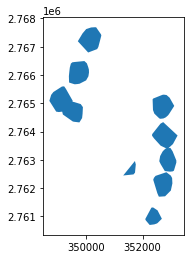

In [14]:
sub_convex2_base.plot()

In [98]:
roads = ['北新路一段','北新路二段','北新路三段','寶橋路','中興路三段','中央路']
main_roads = gdf2[ (gdf2.name.apply(lambda x :x in roads)) |\
    ( (gdf2.name=='中正路') & (gdf2.ref=='北101') ) |\
    ( (gdf2.name=='中正路') & (gdf2.ref=='北95') ) |\
    ( (gdf2.name=='民權路') & (gdf2.ref=='北96') ) ]

main_roads_buffer = main_roads.copy()
main_roads_buffer = main_roads_buffer.to_crs(epsg=3826)
main_roads_buffer['geometry'] = main_roads_buffer.buffer(50)
main_roads_buffer = main_roads_buffer.dissolve(by='name').reset_index()

<AxesSubplot:>

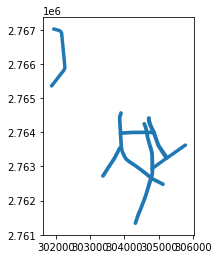

In [99]:
main_roads_buffer.plot()

In [16]:
f_path = os.path.join(dir_data, 'Real estate valuation data set.xlsx')
print('Path of read in data: %s' % (f_path))

df = pd.read_excel(f_path)

Path of read in data: ./data/Real estate valuation data set.xlsx


In [17]:
print(np.array(df.columns))
df.columns = ['No','Trans_Date','Age','D2MRT','n_convenience_stores','lat','lon','Y']
print(np.array(df.columns))

['No' 'X1 transaction date' 'X2 house age'
 'X3 distance to the nearest MRT station'
 'X4 number of convenience stores' 'X5 latitude' 'X6 longitude'
 'Y house price of unit area']
['No' 'Trans_Date' 'Age' 'D2MRT' 'n_convenience_stores' 'lat' 'lon' 'Y']


In [18]:
# 查看資料大小
print('Data shape: ', df.shape)

Data shape:  (414, 8)


In [19]:
# 查看資料內容
def columns_type(df_data):
    dtype_df = df_data.dtypes.reset_index()
    dtype_df.columns = ['Columns', 'Type']
    dtype_df_count = dtype_df.groupby(['Type'])['Columns'].count().reset_index()
    for t, n in zip(dtype_df_count.Type, dtype_df_count.Columns):
        print('類型 : ',t,'\n')
        print('  個數 : ',n,'\n')
        print('  ',list(dtype_df[dtype_df.Type==t].Columns),'\n')
        print('-----------------------------------------------\n')
        
def object_check(df_data):    
    object_type = df_data.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).reset_index() 
    object_type.columns = ["Column", "Unique Count"]
    display(object_type.head(10))        
        
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
    
    
columns_type(df)
object_check(df)
print('\n')
print('Data na_check')
na_check(df)

類型 :  int64 

  個數 :  2 

   ['No', 'n_convenience_stores'] 

-----------------------------------------------

類型 :  float64 

  個數 :  6 

   ['Trans_Date', 'Age', 'D2MRT', 'lat', 'lon', 'Y'] 

-----------------------------------------------



Empty DataFrame
Columns: [Column, Unique Count]
Index: []



Data na_check


Empty DataFrame
Columns: [Missing Ratio]
Index: []

In [20]:
df_train = df.copy()

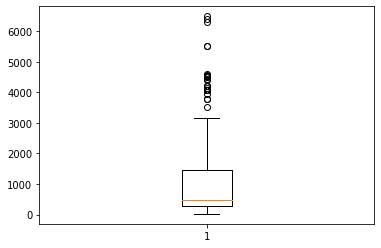

In [21]:
plt.boxplot(df_train['D2MRT'])
plt.show()

In [25]:
df_train = df_train[df_train['Y']<100].reset_index(drop=True)
df_train['D2MRT'][df_train['D2MRT']>2000]=2000

In [26]:
#想畫顏色的變數
variable='Y'

#設定色階
df_train['id']=df_train.index
color=df_train.set_index('id')[variable]

high=round(color.max(),1)
low=color.min()
p=high/8
print(p)

colorscale_Y = branca.colormap.linear.YlOrRd_09.scale(low, high)
#colorscale = branca.colormap.linear.YlGnBu_09.scale(low, 0.4)
colorscale_Y

9.7875


In [27]:
df_train['color'] = color.apply(lambda x : colorscale(x))

In [28]:
f_path = os.path.join(dir_data, 'GIS/重劃區/重劃區.xlsx')
print('Path of read in data: %s' % (f_path))
re_location = pd.read_excel(f_path)

Path of read in data: ./data/GIS/重劃區/重劃區.xlsx


In [29]:
re_location =re_location.loc[ (-(re_location['year']>100)) & (re_location['city'].isin(['新北市'])) \
                & ((re_location['name'].apply(lambda x:'新店' in x)) | (re_location['name'].apply(lambda x:'中和' in x)) \
                   | (re_location['name'].apply(lambda x:'永和' in x)) | (re_location['name'].apply(lambda x:'寶橋' in x)) ) \
                             ,:].reset_index(drop=True)

In [30]:
re_location

year city                name casetypes condition        lat         lon
0    NaN  新北市      新店禾豐第二期自辦市地重劃區         B      辦理完成  24.935564  121.510795
1    NaN  新北市     新店華城秀岡三期自辦市地重劃區         B      辦理完成  24.916239  121.494472
2    NaN  新北市     新店華城秀岡一期自辦市地重劃區         B      辦理完成  24.912492  121.501415
3    NaN  新北市      新店禾豐第三期自辦市地重劃區         B      辦理完成  24.934337  121.509754
4    NaN  新北市       新店碧潭大橋北側(F單元)         A       規劃中  24.964916  121.530459
5    NaN  新北市       台北縣(第五期)新店大坪林         B      辦理完成  24.972117  121.536894
6    NaN  新北市                中和灰磘         A       規劃中  24.985181  121.482363
7    NaN  新北市          新店十四張(B單元)         A       規劃中  24.984509  121.529770
8    NaN  新北市      新店禾豐第一期自辦市地重劃區         B      辦理完成  24.936810  121.510348
9    NaN  新北市        第二期永和和平市地重劃區         B      辦理完成  25.005802  121.508277
10   NaN  新北市  新店安坑輕軌K8站周邊地區(J單元)         A       規劃中  24.981089  121.518284
11   NaN  新北市       新店市復興段自辦市地重劃區         B      辦理完成  24.984893  121.536980
12   NaN  新北市     新店華城秀岡四期自辦市地重劃區         B      辦理完成  24.916436  121.500176
13  71.0  新北市             新店直潭淨水場         A      辦理完成  24.943288  121.531440
14  91.0  新北市   新店區(七張地區)五峰自辦市地重劃         B      辦理完成  24.969538  121.543070
15  94.0  新北市          裕隆寶橋自辦市地重劃         B      辦理完成  24.979488  121.547254
16  96.0  新北市          中和泰隆自辦市地重劃         B      辦理完成  25.007562  121.496951
17  97.0  新北市          中和元隆自辦市地重劃         B      辦理完成  25.006937  121.486239
18  97.0  新北市          新北市中和華中橋西側         A      辦理完成  25.009793  121.489464

In [31]:
geom = [Point(data.lon,data.lat) for idx,data in re_location.iterrows()]
crs = {'init': 'epsg:4326'}
re_location = gpd.GeoDataFrame(re_location, crs=crs, geometry=geom)
re_location = re_location.to_crs(epsg=3826)

In [32]:
re_location_buffer = re_location.copy()
re_location_buffer['geometry'] = re_location_buffer.buffer(500)
re_location_buffer = re_location_buffer.dissolve(by='city').reset_index()

In [33]:
f_path = os.path.join(dir_data, 'GIS/村里邊界/VILLAGE_MOI_1090423.shp')
print('Path of read in data: %s' % (f_path))

gdf = gpd.read_file(f_path,encoding='utf-8')
gdf=gdf.loc[:,['COUNTYNAME','TOWNNAME','VILLNAME','geometry']]
gdf=trans(gdf)
print(gdf.shape)
gdf=gdf.dropna().reset_index(drop=True)
gdf.columns=['縣市','行政區','村里','geometry']
print(gdf.shape)
gdf.head(5)

Path of read in data: ./data/GIS/村里邊界/VILLAGE_MOI_1090423.shp
(7965, 4)
(7760, 4)


縣市  行政區   村里                                           geometry
0  高雄市  林園區  中門里  POLYGON ((120.36772 22.49564, 120.36427 22.498...
1  高雄市  林園區  港埔里  POLYGON ((120.37325 22.49123, 120.37147 22.492...
2  高雄市  旗津區  上竹里  POLYGON ((120.28976 22.57317, 120.28577 22.577...
3  高雄市  旗津區  中興里  POLYGON ((120.30320 22.55568, 120.30284 22.557...
4  連江縣  南竿鄉  津沙村  POLYGON ((119.91684 26.14109, 119.91683 26.141...

In [34]:
gdf_boundry=gdf.loc[ ( (gdf['縣市'].isin(['臺北市','新北市'])) & (gdf['行政區'].isin(['新店區','中和區','永和區','文山區']))), :]

gdf_boundry=gdf_boundry.dissolve(by='行政區').reset_index()
gdf_boundry

行政區                                           geometry   縣市   村里
0  中和區  POLYGON ((121.46811 24.99369, 121.46806 24.993...  新北市  華新里
1  文山區  POLYGON ((121.59606 25.00431, 121.59613 25.004...  臺北市  樟新里
2  新店區  POLYGON ((121.56652 24.90373, 121.56650 24.903...  新北市  龜山里
3  永和區  POLYGON ((121.50822 25.00247, 121.50830 25.002...  新北市  智光里

In [35]:
f_path = os.path.join(dir_data, 'GIS/所得/2012年村里所得資料.csv')
print('Path of read in data: %s' % (f_path))
Income = pd.read_csv(f_path)

Income = Income[-Income['村里'].isin(['合計','其他'])].reset_index(drop=True)
Income.rename(columns={'鄉鎮市區':'行政區'},inplace=True)

Income['村里']=Income['村里'].apply(lambda x:x.replace('五峰里','五峯里'))
Income['村里']=Income['村里'].apply(lambda x:x.replace('灰\U000fc355里','灰磘里'))
Income['村里']=Income['村里'].apply(lambda x:x.replace('瓦\U000fc355里','瓦磘里'))
Income['村里']=Income['村里'].apply(lambda x:x.replace('新\U000fffb4里','新廍里'))

Path of read in data: ./data/GIS/所得/2012年村里所得資料.csv


In [36]:
gdf_sub = gdf.loc[ ( (gdf['縣市'].isin(['臺北市','新北市'])) & (gdf['行政區'].isin(['新店區','中和區','永和區','文山區']))), :].reset_index(drop=True)

In [37]:
gdf_sub[-(gdf_sub['縣市'] + gdf_sub['行政區']+ gdf_sub['村里']).isin(Income['縣市'] + Income['行政區']+ Income['村里'])]

Empty GeoDataFrame
Columns: [縣市, 行政區, 村里, geometry]
Index: []

In [38]:
#Income[(Income['縣市'] + Income['行政區']).isin(['新北市永和區'])]['村里'].unique()

In [39]:
Income['site'] = Income['縣市'] + Income['行政區']+ Income['村里']
gdf_sub['site'] = gdf_sub['縣市'] + gdf_sub['行政區']+ gdf_sub['村里']

In [40]:
gdf_final = pd.merge(gdf_sub,Income)

In [41]:
gdf_final.head(2)

縣市  行政區   村里                                           geometry  \
0  新北市  新店區  龜山里  POLYGON ((121.54472 24.91309, 121.54504 24.913...   
1  新北市  新店區  廣興里  POLYGON ((121.53402 24.91970, 121.53403 24.919...   

        site  納稅單位  綜合所得總額  平均數  中位數  第一分位數  第三分位數      標準差    變異係數  
0  新北市新店區龜山里   430  312115  726  475    313    863  1108.22  152.68  
1  新北市新店區廣興里   299  202586  678  517    317    791   635.52   93.80

In [42]:
gdf_final.describe()

納稅單位        綜合所得總額          平均數          中位數       第一分位數  \
count   267.000000  2.670000e+02   267.000000   267.000000  267.000000   
mean   1394.217228  1.400155e+06   969.119850   661.205993  379.910112   
std     628.622774  8.147428e+05   269.588688   103.666608   37.269585   
min      86.000000  5.177700e+04   602.000000   459.000000  288.000000   
25%     973.500000  8.729255e+05   816.500000   584.500000  357.500000   
50%    1326.000000  1.179105e+06   939.000000   652.000000  377.000000   
75%    1710.000000  1.806106e+06  1047.000000   708.000000  400.000000   
max    3412.000000  4.198788e+06  3678.000000  1275.000000  603.000000   

             第三分位數           標準差        變異係數  
count   267.000000    267.000000  267.000000  
mean   1187.599251   1392.231948  130.221461  
std     255.247971   1710.329373   80.806752  
min     736.000000    448.340000   74.430000  
25%    1006.000000    802.965000   93.430000  
50%    1162.000000   1014.880000  105.800000  
75%    1305.500000   1323.285000  127.040000  
max    2667.000000  22192.710000  721.060000

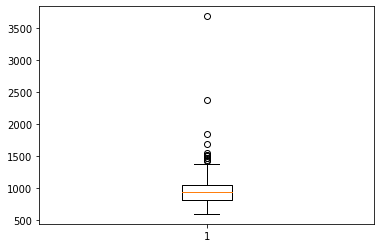

In [43]:
plt.boxplot(gdf_final['平均數'])
plt.show()

In [44]:
site=['基隆市','新北市', '台北市','桃園市','新竹縣','新竹市','苗栗縣','台中市','彰化縣','南投縣',
      '雲林縣','嘉義縣','嘉義市','台南市',
      '高雄市','屏東縣','宜蘭縣','花蓮縣','台東縣',
      '澎湖縣','金門縣','連江縣']

site_colors={'基隆市':'#6e5e4c','新北市':'#6e5e4c', '台北市':'#6e5e4c',
            '桃園市':'#968278','新竹縣':'#968278','新竹市':'#968278','苗栗縣':'#968278',
            '台中市':'#6e5e4c','彰化縣':'#6e5e4c','南投縣':'#6e5e4c','澎湖縣':'#6e5e4c','金門縣':'#6e5e4c','連江縣':'#6e5e4c',
            '雲林縣':'#968278','嘉義縣':'#968278','嘉義市':'#968278','台南市':'#968278',
            '高雄市':'#6e5e4c','屏東縣':'#6e5e4c',
            '宜蘭縣':'#968278','花蓮縣':'#968278','台東縣':'#968278'}

#想畫顏色的變數
variable='平均數'

#設定色階
gdf_final['id']=gdf_final.index
color=gdf_final.set_index('id')[variable]

high=round(color.max(),1)
low=color.min()
p=high/8
print(p)

colorscale = branca.colormap.linear.YlOrRd_09.scale(low, high)
#colorscale = branca.colormap.linear.YlGnBu_09.scale(low, 0.4)
colorscale

459.75


In [45]:
# 顏色 style
def style_function(feature):
    colors = color.get(int(feature['id']), None)
    site_color=site_colors.get(feature['properties']['縣市'])
    return {
        'fillOpacity': 0.5,
        'weight': 1,
        'color':site_color,
        'fillColor': '#fff' if colors is None else colorscale(colors)
    }

In [46]:
# 篩選縣市
site2=site[1:3]
print(site2)

['新北市', '台北市']


In [47]:
# 各車站定位
台北車站=[25.047741, 121.517384]
中壢車站=[24.953737, 121.225607]
台中車站=[24.137264, 120.686669]
嘉義車站=[23.479119, 120.441138]

In [48]:
# 設定圖例
colormap=colorscale.to_step(index=[0, p*1, p*2, p*3, p*4,p*5,p*6,p*7,p*8])
#colormap.caption ='The Number of Loss Member'
colormap.caption ='Income'
#colormap.caption ='Average Consumption'

In [49]:
# 設定圖例
colormap_Y=colorscale_Y
#colormap.caption ='The Number of Loss Member'
colormap_Y.caption ='Y'
#colormap.caption ='Average Consumption'

In [81]:
# 設定地圖一開始顯示的中心與大小
mm=folium.Map(location=台北車站,zoom_start=12,\
              #tiles="Cartodb Positron"\
             )

#行政區邊界
dis=1
if dis==1:
    folium.GeoJson(
        gdf_boundry,
        style_function = lambda x: {
            'color': '#642100',
            'weight': 4,
            'fillOpacity': 0.2
        },
        name='行政區邊界').add_to(mm)

# 重劃區
re_loc=1
if re_loc==1:
    folium.GeoJson(
        re_location_buffer,
        style_function = lambda x: {
            'color': '#408080',
            'weight': 6,
            'dash_array':'10',
            'fillOpacity': 0
        },
        name='重劃區').add_to(mm)

    
# 所得
folium.GeoJson(
    gdf_final[['geometry','縣市','行政區','村里','平均數','中位數','標準差']],
    name='所得', 
    style_function=style_function,
    highlight_function=lambda x: {'weight':3, 
                                    'color':site_colors.get(x['properties']['縣市']),
                                    'fillOpacity':0.75},
    smooth_factor=2.0,
    tooltip=folium.features.GeoJsonTooltip(fields=['縣市','行政區','村里','平均數','中位數'],
                                                aliases=['縣市','行政區','村里','平均數','中位數'], 
                                                labels=True, 
                                                sticky=True,
                                                toLocaleString=True
                                                )
).add_to(mm)    
    
    


#捷運路線
folium.GeoJson(
        gdf_mrt.loc[gdf_mrt['MRTCODE'].isin(['松山新店線','小碧潭線','中和新蘆線']),:],
        
        name='捷運路線').add_to(mm)

#捷運站
if 1==1:
    #MRT_cluster = MarkerCluster(name='MRT').add_to(mm)
    fg1=folium.FeatureGroup(name='MRT', show=True)
    for i in range(MRT.shape[0]):
        if MRT.line_code[i] in ['G','O']:
            iframe = IFrame(html=heading3(utf2asc(MRT.station_name_tw[i])),width=250,height=50)
            popup = folium.Popup(iframe)
            folium.Marker(location=[MRT.lat[i], MRT.lon[i]],
                           popup=popup,
                           icon=folium.Icon(icon='train',
                                            color='black',
                                            icon_color=MRT.color[i],
                                            prefix='fa')).add_to(fg1)
    mm.add_child(fg1)

#距離遠近
if 1==1:
    fg2=folium.FeatureGroup(name='遠', show=True)
    fg3=folium.FeatureGroup(name='中', show=True)
    fg4=folium.FeatureGroup(name='近', show=True)
    '''
    fg5=folium.FeatureGroup(name='中1', show=True)
    fg6=folium.FeatureGroup(name='中2', show=True)
    fg7=folium.FeatureGroup(name='中3', show=True)
    fg8=folium.FeatureGroup(name='近1', show=True)
    fg9=folium.FeatureGroup(name='近2', show=True)
    fg10=folium.FeatureGroup(name='近3', show=True)
    '''

    folium.Choropleth(geo_data=sub_convex0_base,fill_color=iso_colors[0],fill_opacity=0.15).add_to(fg2)
    mm.add_child(fg2)
    folium.Choropleth(geo_data=sub_convex1_base,fill_color=iso_colors[1],fill_opacity=0.175).add_to(fg3)
    mm.add_child(fg3)
    folium.Choropleth(geo_data=sub_convex2_base,fill_color=iso_colors[2],fill_opacity=0.2).add_to(fg4)
    mm.add_child(fg4)
    '''
    folium.Choropleth(geo_data=sub_convex3_base,fill_color=iso_colors[3],fill_opacity=0.15).add_to(fg5)
    mm.add_child(fg5)
    folium.Choropleth(geo_data=sub_convex4_base,fill_color=iso_colors[4],fill_opacity=0.15).add_to(fg6)
    mm.add_child(fg6)
    folium.Choropleth(geo_data=sub_convex5_base,fill_color=iso_colors[5],fill_opacity=0.15).add_to(fg7)
    mm.add_child(fg7)
    folium.Choropleth(geo_data=sub_convex6_base,fill_color=iso_colors[6],fill_opacity=0.15).add_to(fg8)
    mm.add_child(fg8)
    folium.Choropleth(geo_data=sub_convex7_base,fill_color=iso_colors[7],fill_opacity=0.15).add_to(fg9)
    mm.add_child(fg9)
    folium.Choropleth(geo_data=sub_convex8_base,fill_color=iso_colors[8],fill_opacity=0.15).add_to(fg10)
    mm.add_child(fg10)
    '''

#道路交叉口
if 1==0:
    fg5=folium.FeatureGroup(name='道路交叉口', show=True)
    for idx,data in gdf1.iterrows():
        if idx==center_node:
            folium.Circle([data.geometry.y,data.geometry.x],radius=100,color='yellow',fill=True).add_to(fg5)
            folium.Circle([data.geometry.y,data.geometry.x],radius=20,color=data.color).add_to(fg5)
        else:
            folium.Circle([data.geometry.y,data.geometry.x],radius=20,color=data.color).add_to(fg5)
    mm.add_child(fg5)    

if 1==1:
    fg6=folium.FeatureGroup(name='主要幹道', show=True)
    folium.Choropleth(geo_data=main_roads_buffer,fill_color='yellow',fill_opacity=0.5).add_to(fg6)
    mm.add_child(fg6)

#房屋位置
if 1==1:
    num=df_train.shape[0]
    lat=np.array(df_train["lat"][0:num])
    lon=np.array(df_train["lon"][0:num])
    data1=[[lat[i],lon[i],1] for i in range(num)]
    fg1=folium.FeatureGroup(name='房屋(點)', show=True)
    for i in range(num):
        folium.Circle(location=[data1[i][0],data1[i][1]],
        color=df_train['color'][i], # Circle 顏色
        radius=25, # Circle 寬度
        popup=df_train['Y'][i],
        fill=True, # 填滿中間區域
        fill_opacity=0.7 # 設定透明度
        ).add_to(fg1)
    mm.add_child(fg1)    
    
    
#colormap.add_to(mm)
colormap_Y.add_to(mm)

folium.LayerControl().add_to(mm)

In [82]:
mm

In [445]:
df_train.shape

(413, 10)

In [383]:
df_train = df.copy()

In [384]:
df_train['Year'] = df_train['Trans_Date'].astype('int')
df_train['Month'] = (((df_train['Trans_Date'] - df_train['Trans_Date'].astype('int')) * 12) + 1).astype('int')

In [385]:
df_train

No   Trans_Date   Age       D2MRT  n_convenience_stores       lat  \
0      1  2012.916667  32.0    84.87882                    10  24.98298   
1      2  2012.916667  19.5   306.59470                     9  24.98034   
2      3  2013.583333  13.3   561.98450                     5  24.98746   
3      4  2013.500000  13.3   561.98450                     5  24.98746   
4      5  2012.833333   5.0   390.56840                     5  24.97937   
..   ...          ...   ...         ...                   ...       ...   
409  410  2013.000000  13.7  4082.01500                     0  24.94155   
410  411  2012.666667   5.6    90.45606                     9  24.97433   
411  412  2013.250000  18.8   390.96960                     7  24.97923   
412  413  2013.000000   8.1   104.81010                     5  24.96674   
413  414  2013.500000   6.5    90.45606                     9  24.97433   

           lon     Y  Year  Month  
0    121.54024  37.9  2012     12  
1    121.53951  42.2  2012     12  
2    121.54391  47.3  2013      7  
3    121.54391  54.8  2013      7  
4    121.54245  43.1  2012     10  
..         ...   ...   ...    ...  
409  121.50381  15.4  2013      1  
410  121.54310  50.0  2012      9  
411  121.53986  40.6  2013      4  
412  121.54067  52.5  2013      1  
413  121.54310  63.9  2013      7  

[414 rows x 10 columns]

In [386]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('Y')
quantitative.remove('No')
quantitative.remove('Year')
quantitative.remove('Month')
quantitative.remove('Trans_Date')
quantitative.remove('lat')
quantitative.remove('lon')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

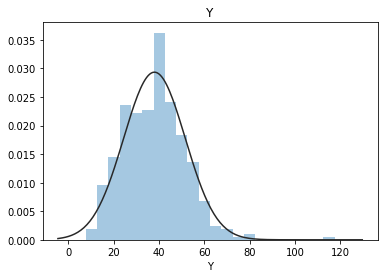

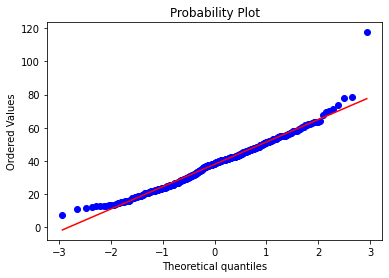

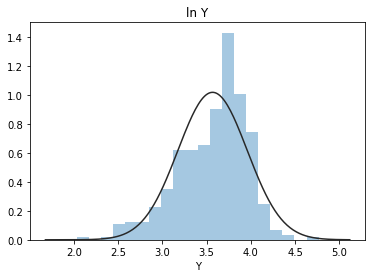

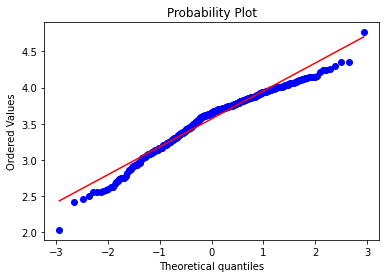

In [387]:
plt.figure(1)
plt.title('Y')
sns.distplot(df_train['Y'], kde=False, fit=st.norm)

plt.figure(2)
res = st.probplot(df_train['Y'],plot=plt)

plt.figure(3)
plt.title('ln Y')
sns.distplot(np.log(df_train['Y']), kde=False, fit=st.norm)

plt.figure(4)
res =  st.probplot(np.log(df_train['Y']),plot=plt)

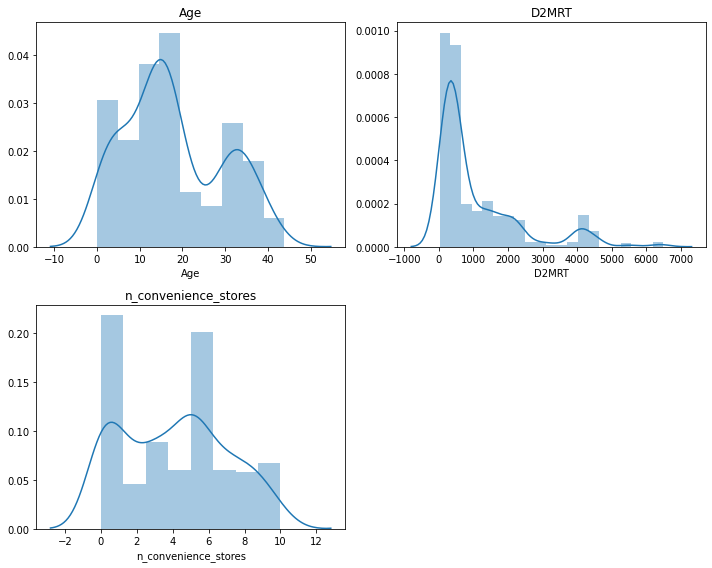

In [388]:
# 單變數

# 設定繪圖區域的長與寬
fig = plt.figure(figsize = (10, 8), dpi=72, 
           facecolor="white",edgecolor="green")

# 設定子圖
ax_1 = fig.add_subplot(2, 2, 1)
sns.distplot(df_train.loc[:, 'Age'])
ax_1.set_title("Age")

ax_2 = fig.add_subplot(2, 2, 2)
sns.distplot(df_train.loc[:, 'D2MRT'])
ax_2.set_title("D2MRT")

ax_3 = fig.add_subplot(2, 2, 3)
sns.distplot(df_train.loc[:, 'n_convenience_stores'])
ax_3.set_title("n_convenience_stores")

fig.tight_layout() # 子圖間距
plt.plot()
plt.show()

In [389]:
df_train['ln_D2MRT']=np.log1p(df_train['D2MRT'])

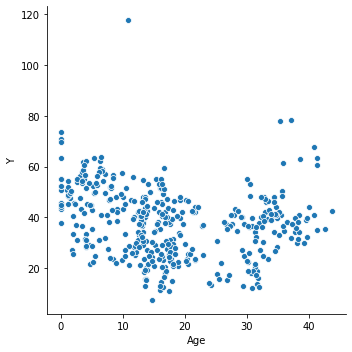

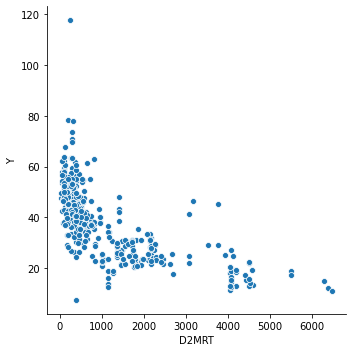

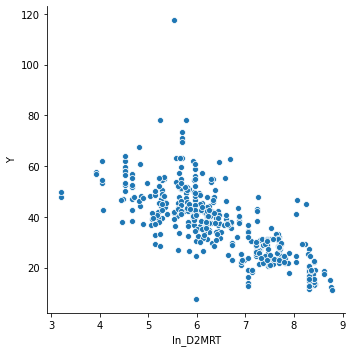

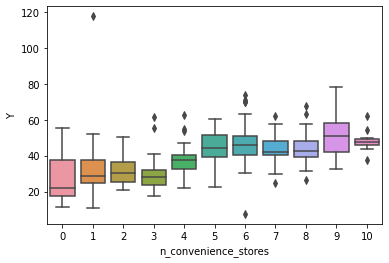

In [390]:
sns.relplot(x = 'Age', y = 'Y', kind="scatter",data=df_train)
plt.show()

sns.relplot(x = 'D2MRT', y = 'Y', kind="scatter",data=df_train)
plt.show()

sns.relplot(x = 'ln_D2MRT', y = 'Y', kind="scatter",data=df_train)
plt.show()

sns.boxplot(x = 'n_convenience_stores', y = 'Y',data=df_train)
plt.show()

In [391]:
def results_KPI(model,X,Y):
    scores_MSE = cross_validate(model, X, Y,scoring='neg_mean_squared_error',\
                            cv=5,return_estimator=True)
    scores_MAE = cross_validate(model, X, Y,scoring='neg_mean_absolute_error',\
                            cv=5,return_estimator=True)
    scores_R2 = cross_validate(model, X, Y,scoring='r2',\
                            cv=5,return_estimator=True)
    results_KPI = {}
    results_KPI['MSE'] = scores_MSE['test_score'].mean()
    results_KPI['MAE'] = scores_MAE['test_score'].mean()
    results_KPI['R2'] = scores_R2['test_score'].mean()
    return results_KPI

def error_plot(Y, y_pred):
    plt.figure(1)
    plt.title('Error')
    sns.distplot((train_Y.values-y_pred).reshape(-1), kde=False, fit=st.norm)
    plt.show()
    
    sns.scatterplot(Y.values.reshape(-1), (train_Y.values-y_pred).reshape(-1))
    plt.show()

In [395]:
df_train = df.copy()

In [396]:
df_train = df_train[df_train.Y<100].reset_index(drop=True)
df_train['ln_D2MRT']=np.log1p(df_train['D2MRT'])

train_X = df_train.loc[:,['Age', 'ln_D2MRT','n_convenience_stores']]
train_Y = df_train.loc[:,['Y']]

{'MSE': -66.07669149076173, 'MAE': -5.8042667297038575, 'R2': 0.6065048574734585}


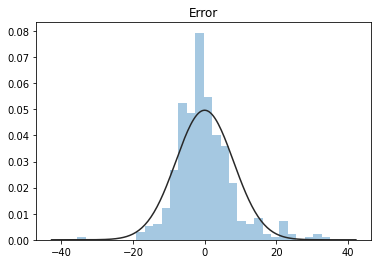

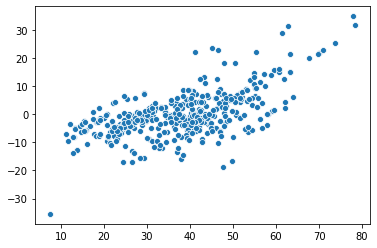

In [397]:
from sklearn.linear_model import LinearRegression
model01 = LinearRegression() # 建立回歸模型

kpi = results_KPI(model01, train_X, train_Y)
print(kpi)

model01.fit(train_X,train_Y)

y_pred = model01.predict(train_X)

error_plot(train_Y,y_pred)

In [400]:
df_train = df.copy()

df_train = df_train[df_train.Y<100].reset_index(drop=True)
df_train['ln_D2MRT']=np.log1p(df_train['D2MRT'])
df_train['Age2']=df_train['Age']**2


train_X = df_train.loc[:,['Age', 'Age2','ln_D2MRT','n_convenience_stores']]
train_Y = df_train.loc[:,['Y']]

{'MSE': -62.59495420756448, 'MAE': -5.838512738807403, 'R2': 0.6281783120401959}


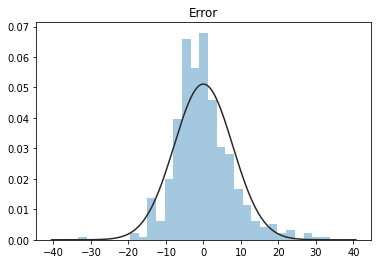

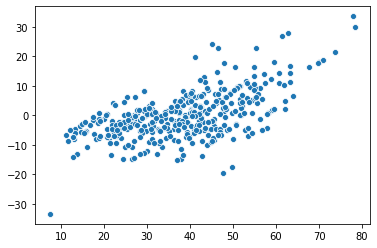

In [401]:
from sklearn.linear_model import LinearRegression
model01 = LinearRegression() # 建立回歸模型

kpi = results_KPI(model01, train_X, train_Y)
print(kpi)

model01.fit(train_X,train_Y)

y_pred = model01.predict(train_X)

error_plot(train_Y,y_pred)

In [402]:
df_train = df.copy()

In [403]:
def trans02(gdf):
    gdf.crs = {'init' :'epsg:4326'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs(epsg=3826)
    return gdf

geom = [Point(data.lon,data.lat) for idx,data in df_train.iterrows()]
crs = {'init': 'epsg:4326'}
df_train = gpd.GeoDataFrame(df_train, crs=crs, geometry=geom)
df_train = trans02(df_train)


geom = [Point(data.lon,data.lat) for idx,data in MRT_sub.iterrows()]
crs = {'init': 'epsg:4326'}
MRT_sub = gpd.GeoDataFrame(MRT_sub, crs=crs, geometry=geom)
MRT_sub = trans02(MRT_sub)

df_train['D2MRT_new']=np.nan
for i in range(df_train.shape[0]):
    df_train['D2MRT_new'][i] = min(MRT_sub.distance(df_train.geometry[i]))



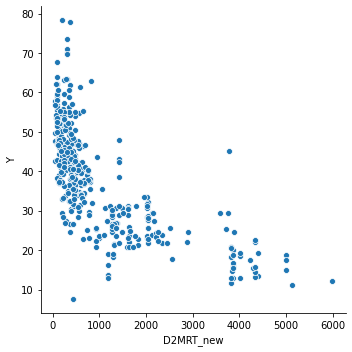

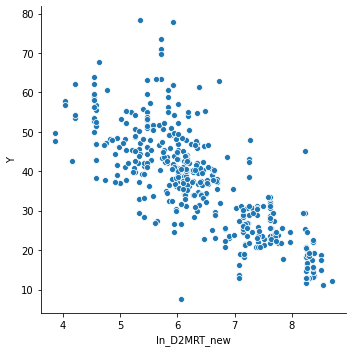

In [404]:
df_train = df_train[df_train.Y<100].reset_index(drop=True)
df_train['ln_D2MRT_new']=np.log1p(df_train['D2MRT_new'])

sns.relplot(x = 'D2MRT_new', y = 'Y', kind="scatter",data=df_train)
plt.show()

sns.relplot(x = 'ln_D2MRT_new', y = 'Y', kind="scatter",data=df_train)
plt.show()

In [405]:
df_train = df.copy()

def trans02(gdf):
    gdf.crs = {'init' :'epsg:4326'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs(epsg=3826)
    return gdf

geom = [Point(data.lon,data.lat) for idx,data in df_train.iterrows()]
crs = {'init': 'epsg:4326'}
df_train = gpd.GeoDataFrame(df_train, crs=crs, geometry=geom)
df_train = trans02(df_train)


geom = [Point(data.lon,data.lat) for idx,data in MRT_sub.iterrows()]
crs = {'init': 'epsg:4326'}
MRT_sub = gpd.GeoDataFrame(MRT_sub, crs=crs, geometry=geom)
MRT_sub = trans02(MRT_sub)

df_train['D2MRT_new']=np.nan
for i in range(df_train.shape[0]):
    df_train['D2MRT_new'][i] = min(MRT_sub.distance(df_train.geometry[i]))

df_train = df_train[df_train.Y<100].reset_index(drop=True)
df_train['ln_D2MRT_new']=np.log1p(df_train['D2MRT_new'])
df_train['Age2']=df_train['Age']**2


train_X = df_train.loc[:,['Age', 'Age2','ln_D2MRT_new','n_convenience_stores']]
train_Y = df_train.loc[:,['Y']]

{'MSE': -59.261546445802175, 'MAE': -5.636656018505771, 'R2': 0.6483874625902313}


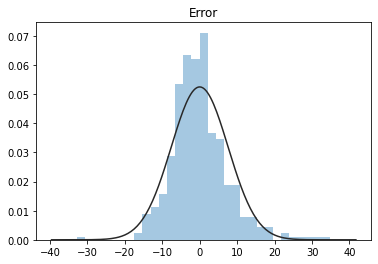

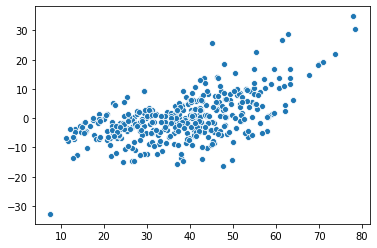

In [406]:
from sklearn.linear_model import LinearRegression
model01 = LinearRegression() # 建立回歸模型

kpi = results_KPI(model01, train_X, train_Y)
print(kpi)

model01.fit(train_X,train_Y)

y_pred = model01.predict(train_X)

error_plot(train_Y,y_pred)

In [407]:
df_train = df.copy()

def trans02(gdf):
    gdf.crs = {'init' :'epsg:4326'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs(epsg=3826)
    return gdf

geom = [Point(data.lon,data.lat) for idx,data in df_train.iterrows()]
crs = {'init': 'epsg:4326'}
df_train = gpd.GeoDataFrame(df_train, crs=crs, geometry=geom)
df_train = trans02(df_train)


geom = [Point(data.lon,data.lat) for idx,data in MRT_sub.iterrows()]
crs = {'init': 'epsg:4326'}
MRT_sub = gpd.GeoDataFrame(MRT_sub, crs=crs, geometry=geom)
MRT_sub = trans02(MRT_sub)

df_train['D2MRT_new']=np.nan
for i in range(df_train.shape[0]):
    df_train['D2MRT_new'][i] = min(MRT_sub.distance(df_train.geometry[i]))

In [408]:
d1 = gpd.sjoin(df_train, sub_convex2_base.to_crs(df_train.crs), op = 'within')['No'].values
d2 = gpd.sjoin(df_train, sub_convex1_base.to_crs(df_train.crs), op = 'within')['No'].values
d3 = gpd.sjoin(df_train, sub_convex0_base.to_crs(df_train.crs), op = 'within')['No'].values
d4 = df_train['No'].values

In [409]:
df_train['d1'] = 0
df_train.loc[ (df_train['No'].isin(d1)) ,['d1']]=1

df_train['d2'] = 0
df_train.loc[ (-df_train['No'].isin(d1) & (df_train['No'].isin(d2))) ,['d2']]=1

df_train['d3'] = 0
df_train.loc[ (-df_train['No'].isin(d1) & (-df_train['No'].isin(d2)) & (df_train['No'].isin(d3))) ,['d3']]=1

In [410]:
df_train = df_train[df_train.Y<100].reset_index(drop=True)
df_train['ln_D2MRT_new']=np.log1p(df_train['D2MRT_new'])
df_train['Age2']=df_train['Age']**2


train_X = df_train.loc[:,['Age', 'Age2','ln_D2MRT_new','n_convenience_stores','d1','d2','d3']]
train_Y = df_train.loc[:,['Y']]

{'MSE': -55.767731064850125, 'MAE': -5.440352712460898, 'R2': 0.6697783426900871}


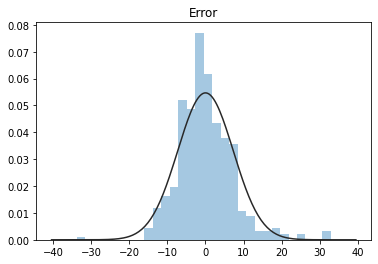

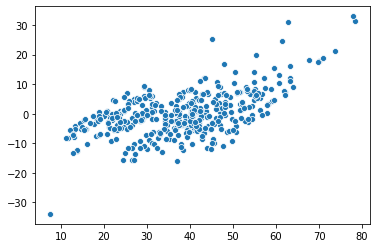

In [411]:
from sklearn.linear_model import LinearRegression
model01 = LinearRegression() # 建立回歸模型

kpi = results_KPI(model01, train_X, train_Y)
print(kpi)

model01.fit(train_X,train_Y)

y_pred = model01.predict(train_X)

error_plot(train_Y,y_pred)

In [412]:
df_train=gpd.sjoin(df_train, gdf_final.loc[:,['site','平均數','中位數','geometry']].to_crs(df_train.crs), op = 'within')

In [413]:
df_train.rename(columns={'平均數':'income_mean','中位數':'income_median'},inplace=True)

In [414]:
df_train = df_train.sort_index().reset_index(drop=True)

In [415]:
df_train['ln_D2MRT_new']=np.log1p(df_train['D2MRT_new'])
df_train['Age2']=df_train['Age']**2


train_X = df_train.loc[:,['Age', 'Age2','ln_D2MRT_new','n_convenience_stores','d1','d2','d3','income_mean']]
train_Y = df_train.loc[:,['Y']]

{'MSE': -53.36068702611548, 'MAE': -5.372071203630577, 'R2': 0.6830980542165794}


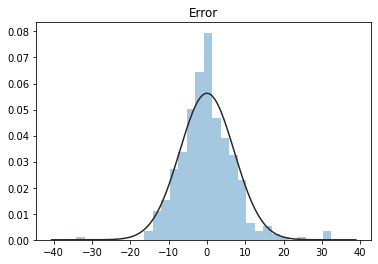

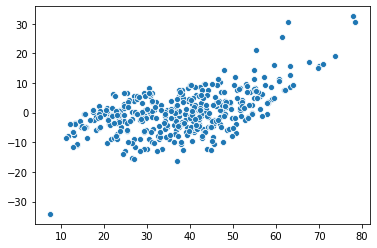

In [416]:
from sklearn.linear_model import LinearRegression
model01 = LinearRegression() # 建立回歸模型

kpi = results_KPI(model01, train_X, train_Y)
print(kpi)

model01.fit(train_X,train_Y)

y_pred = model01.predict(train_X)

error_plot(train_Y,y_pred)

In [92]:
# drive, drive_service, walk, bike, all, all_private
#site_lat = 24.956544
#site_lon = 121.536432
place = '瑠公圳'
G2 = ox.graph_from_place(place)
ox.plot_graph(G2)

ValueError: Nominatim could not geocode query "瑠公圳" to polygonal boundaries

In [93]:
# 中央新村, 新店行政園區
place = '瑠公圳'
site1 = ox.geocode_to_gdf(place)

ValueError: Nominatim could not geocode query "瑠公圳" to polygonal boundaries

<AxesSubplot:>

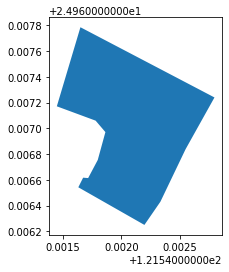

In [89]:
site1.plot()

In [73]:
ox.project_gdf

AttributeError: 'MultiDiGraph' object has no attribute 'crs'

In [68]:
G2 = ox.project_graph(G2) # 投影
gdf3,gdf4=ox.graph_to_gdfs(G2)

In [70]:
gdf3

y              x  street_count         lon        lat  \
osmid                                                                          
1223127282  2.763175e+06  351097.938564             1  121.524787  24.976680   
2937932065  2.763159e+06  351121.056476             3  121.525018  24.976538   
1223127354  2.763340e+06  351102.896047             3  121.524818  24.978173   
3833646125  2.763292e+06  351180.361329             4  121.525591  24.977742   
1223127488  2.763311e+06  351079.849919             2  121.524593  24.977905   
1223127439  2.763376e+06  351125.779981             3  121.525041  24.978499   
1223127383  2.763089e+06  351229.342906             4  121.526098  24.975914   
5981910573  2.763012e+06  351341.625546             3  121.527218  24.975230   
1223127502  2.763127e+06  351255.720027             4  121.526355  24.976257   
1223127408  2.763055e+06  351208.948032             4  121.525899  24.975610   
2937932067  2.763108e+06  351132.057840             3  121.525132  24.976075   
1223127543  2.762965e+06  351335.137623             4  121.527159  24.974804   
2930009322  2.763385e+06  351126.022925             3  121.525043  24.978575   
1223127441  2.763203e+06  351309.950490             4  121.526884  24.976954   
1223127485  2.763123e+06  351427.360136             4  121.528055  24.976243   
1223127609  2.763169e+06  351285.707346             4  121.526647  24.976639   
1223127455  2.763079e+06  351414.095956             4  121.527929  24.975841   
1223127572  2.763040e+06  351388.932185             3  121.527684  24.975491   
1223127472  2.763115e+06  351439.823237             3  121.528180  24.976173   
2076138100  2.763029e+06  351570.211364             3  121.529480  24.975407   
1223127497  2.762852e+06  351347.354339             1  121.527292  24.973789   
3833646126  2.762845e+06  351360.134576             3  121.527419  24.973722   
5951139485  2.763060e+06  351358.955115             3  121.527385  24.975663   
2076138088  2.762875e+06  351466.213751             4  121.528467  24.974006   
1223127596  2.763000e+06  351359.424106             3  121.527396  24.975121   
1223127603  2.762930e+06  351310.072727             3  121.526915  24.974487   
1223127546  2.762979e+06  351393.180274             3  121.527732  24.974935   
2076138098  2.762913e+06  351491.819234             4  121.528716  24.974354   
4416025318  2.763021e+06  351420.899042             3  121.528002  24.975319   
5981910574  2.763054e+06  351367.527177             3  121.527470  24.975614   
1223127577  2.763143e+06  351109.976796             2  121.524910  24.976391   
1223127592  2.763326e+06  351205.770030             3  121.525839  24.978053   
2929992156  2.763258e+06  351158.180611             3  121.525375  24.977430   
2076138090  2.762843e+06  351443.413510             4  121.528244  24.973716   
3833646127  2.762880e+06  351383.069142             3  121.527643  24.974048   
2076138092  2.762804e+06  351418.511317             3  121.528002  24.973366   
2910328663  2.762778e+06  351535.984742             3  121.529168  24.973134   
2076138094  2.762993e+06  351546.653069             4  121.529251  24.975083   
2076138096  2.762957e+06  351522.487751             4  121.529015  24.974749   
2910328664  2.762746e+06  351514.543065             3  121.528959  24.972849   
2910328665  2.762756e+06  351495.157039             1  121.528766  24.972939   
2910328666  2.762739e+06  351525.841753             1  121.529072  24.972783   
2937932066  2.763139e+06  351152.714555             3  121.525333  24.976362   
2937932069  2.763129e+06  351099.671344             3  121.524809  24.976266   
5951139486  2.763034e+06  351340.363753             1  121.527203  24.975431   

                                  geometry  
osmid                                       
1223127282  POINT (351097.939 2763175.097)  
2937932065  POINT (351121.056 2763159.084)  
1223127354  POINT (351102.896 2763340.382)  
3833646125  POINT (351180.361 2763291

In [468]:
origin = ox.get_nearest_node(G2, (24.959180,121.537957))
destination = ox.get_nearest_node(G2, (24.982963,121.541355))

In [471]:
lat=24.959180
lon=121.537957

origin=gdf3[(gdf3.lat-lat)**2+(gdf3.lon-lon)**2==min((gdf3.lat-lat)**2+(gdf3.lon-lon)**2)].index[0]#最近點


In [474]:
lat=24.992764
lon=121.540783

destination=gdf3[(gdf3.lat-lat)**2+(gdf3.lon-lon)**2==min((gdf3.lat-lat)**2+(gdf3.lon-lon)**2)].index[0]#最近點


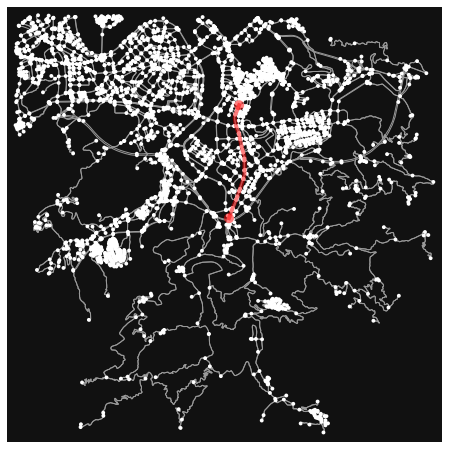

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [475]:
route = nx.shortest_path(G2, origin, destination)
ox.plot_graph_route(G2, route)

In [476]:
route

[1223597791,
 1223954327,
 2081255064,
 2081255107,
 2621844777,
 1223963221,
 2621844779,
 1224128171,
 2076133077,
 1224128126,
 1224128536,
 1224155194,
 2465505577,
 1224155215,
 1224155118,
 2958540129,
 1224155306,
 345178350,
 1224155251,
 282283330,
 4392471442,
 1224984836,
 2838870917,
 2317000855]

In [448]:
lat=24.973590
lon=121.542889

center_node=gdf3[(gdf3.lat-lat)**2+(gdf3.lon-lon)**2==min((gdf3.lat-lat)**2+(gdf3.lon-lon)**2)].index[0]#最近點


In [457]:
center_node

1224155194

In [461]:
gdf3[gdf3.index==center_node]

y             x  street_count         lon        lat  \
osmid                                                                         
1224155194  2.762797e+06  352930.10785             4  121.542974  24.973442   

            ref          highway                        geometry  
osmid                                                             
1224155194  NaN  traffic_signals  POINT (352930.108 2762796.608)

In [96]:
roads = ['北新路一段','北新路二段','北新路三段','寶橋路','中興路三段','中央路']
main_roads = gdf2[ (gdf2.name.apply(lambda x :x in roads)) |\
    ( (gdf2.name=='中正路') & (gdf2.ref=='北101') ) |\
    ( (gdf2.name=='民權路') & (gdf2.ref=='北96') ) ]

main_roads_buffer = main_roads.copy()
main_roads_buffer = main_roads_buffer.to_crs(epsg=3826)
main_roads_buffer['geometry'] = main_roads_buffer.buffer(50)
main_roads_buffer = main_roads_buffer.dissolve(by='name').reset_index()

In [99]:
main_roads

osmid  oneway lanes   ref   name  \
u          v          key                                                      
48075827   5068044952 0                 229193805    True   NaN   北96    民權路   
5068044952 2088841715 0                 229193805    True   NaN   北96    民權路   
1223577372 1223577074 0                 302205896    True   NaN   NaN    中央路   
282282891  3365328803 0    [198414888, 441500155]    True     2     9  北新路三段   
3365328803 2085453844 0                 198414888    True     2     9  北新路三段   
...                                           ...     ...   ...   ...    ...   
4866466731 3365328799 0                 238742346    True     2     9  北新路三段   
4866466732 3101858904 0                 106373374    True     2     9  北新路三段   
5083164459 1224155174 0                 308447241    True   NaN   北96    民權路   
5068044957 3750231913 0                 238483774    True   NaN   北96    民權路   
5101629282 1224155078 0                 106273075    True     2  北101    中正路   

                                 highway maxspeed   length bridge  \
u          v          key                                           
48075827   5068044952 0         tertiary      NaN    9.233    NaN   
5068044952 2088841715 0         tertiary      NaN   21.146    NaN   
1223577372 1223577074 0    motorway_link      NaN   71.074    NaN   
282282891  3365328803 0          primary       50   65.877    NaN   
3365328803 2085453844 0          primary       50   44.518    NaN   
...                                  ...      ...      ...    ...   
4866466731 3365328799 0          primary      NaN   12.740    NaN   
4866466732 3101858904 0          primary       50  167.424    NaN   
5083164459 1224155174 0         tertiary      NaN    3.267    NaN   
5068044957 3750231913 0         tertiary      NaN   51.864    NaN   
5101629282 1224155078 0         tertiary      NaN   68.907    NaN   

                                                                    geometry  \
u          v          key                                                      
48075827   5068044952 0    LINESTRING (352401.225 2763850.097, 352410.472...   
5068044952 2088841715 0    LINESTRING (352410.472 2763850.097, 352431.650...   
1223577372 1223577074 0    LINESTRING (351511.783 2762656.466, 351496.720...   
282282891  3365328803 0    LINESTRING (352749.521 2763969.882, 352750.290...   
3365328803 2085453844 0    LINESTRING (352763.500 2763905.754, 352770.298...   
...                                                                      ...   
4866466731 3365328799 0    LINESTRING (352822.904 2763599.682, 352826.225...   
4866466732 3101858904 0    LINESTRING (352830.903 2763601.900, 352824.440...   
5083164459 1224155174 0    LINESTRING (352395.819 2763849.679, 352399.064...   
5068044957 3750231913 0    LINESTRING (352385.454 2763858.419, 352362.141...   
5101629282 1224155078 0    LINESTRING (352002.383 2763907.825, 352005.357...   

                          access tunnel service width junction  
u          v          key                                       
48075827   5068044952 0      NaN    NaN     NaN   NaN      NaN  
5068044952 2088841715 0      NaN    NaN     NaN   NaN      NaN  
1223577372 1223577074 0      NaN    NaN     NaN   NaN      NaN  
282282891  3365328803 0      NaN    NaN     NaN   NaN      NaN  
3365328803 2085453844 0      NaN    NaN     NaN   NaN      NaN  
...                          ...    ...     ...   ...      ...  
4866466731 3365328799 0      NaN    NaN     NaN   NaN      NaN  
4866466732 3101858904 0      NaN    NaN     NaN   NaN      NaN  
5083164459 1224155174 0      NaN    NaN     NaN   NaN      NaN  
5068044957 3750231913 0      NaN    NaN     NaN   NaN      NaN  
5101629282 1224155078 0      NaN    NaN     NaN   NaN      NaN  

[402 rows x 15 columns]

In [100]:
main_roads_buffer = main_roads.copy()
main_roads_buffer = main_roads_buffer.to_crs(epsg=3826)
main_roads_buffer['geometry'] = main_roads_buffer.buffer(50)
main_roads_buffer = main_roads_buffer.dissolve(by='name').reset_index()

<AxesSubplot:>

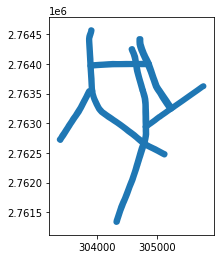

In [102]:
main_roads_buffer.plot()

In [80]:
 ( (gdf2.name=='中正路') & gdf2.ref=='北101' ).sum()

0

In [81]:
(gdf2.name=='中正路').sum()

300

In [94]:
roads = ['中正路']
gdf2_2 = gdf2[gdf2.name.apply(lambda x :x in roads)]

<AxesSubplot:>

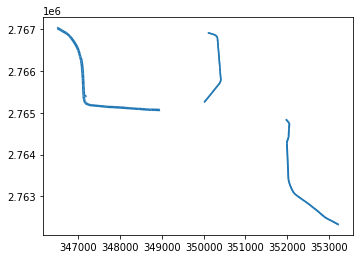

In [95]:
gdf2_2.plot()

In [96]:
gdf2_2.ref.unique()

array([nan, '北95', '北101'], dtype=object)

<AxesSubplot:>

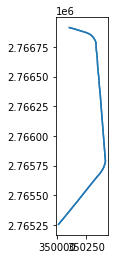

In [97]:
gdf2_2[gdf2_2.ref == '北95'].plot()

In [338]:
(df_train['income_median']>gdf_final['中位數'].describe()['mean']).sum()

258

In [342]:
gdf_final['中位數'].describe()['mean']

661.2059925093633

In [346]:
MinMaxScaler(feature_range=(0, 1)).fit_transform(df_train.loc[:,['income_median']])

array([[0.10408432],
       [0.10408432],
       [0.10408432],
       [0.10408432],
       [0.10408432],
       [0.10408432],
       [0.10408432],
       [0.10408432],
       [0.10408432],
       [0.10408432],
       [0.23715415],
       [0.23715415],
       [0.23715415],
       [0.23715415],
       [0.23715415],
       [0.23715415],
       [0.23715415],
       [0.23715415],
       [0.23188406],
       [0.23188406],
       [0.23188406],
       [0.23188406],
       [0.23188406],
       [0.23188406],
       [0.23188406],
       [0.23188406],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.18445323],
       [0.184

In [296]:
sub_convex0_base.to_crs(df_train.crs)

df                                           geometry
0   0  POLYGON ((299924.719 2766540.519, 299939.918 2...

In [ ]:
mae = metrics.mean_absolute_error(prediction, y) # 使用 MAE 評估
mse = metrics.mean_squared_error(prediction, y) # 使用 MSE 評估
r2 = metrics.r2_score(prediction, y) # 使用 r-square 評估
print("MAE: ", mae)
print("MSE: ", mse)
print("R-square: ", r2)

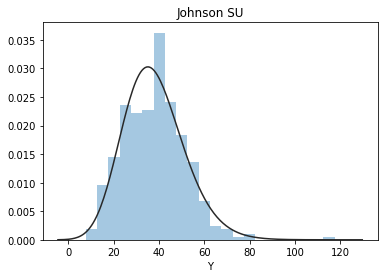

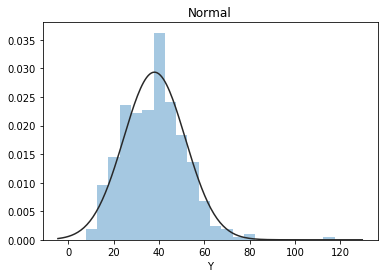

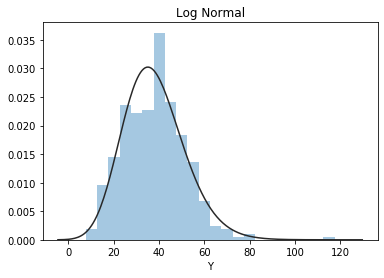

In [55]:
import scipy.stats as st
y = df_train['Y']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

In [73]:
st.normaltest (st.boxcox(y)[0], axis=0)

NormaltestResult(statistic=2.906614531131732, pvalue=0.2337957833096727)

In [74]:
st.shapiro(st.boxcox(y)[0])

(0.9883732199668884, 0.0022127400152385235)

In [75]:
st.normaltest (np.log(y), axis=0)

NormaltestResult(statistic=2.906614531131732, pvalue=0.2337957833096727)

In [61]:
st.shapiro(np.log(y))

(0.9638436436653137, 1.4281789084691354e-08)

In [60]:
np.log(y)

0      1.290596
1      1.319733
2      1.349763
3      1.387216
4      1.325355
         ...   
409    1.005900
410    1.364055
411    1.309351
412    1.376449
413    1.424870
Name: Y, Length: 414, dtype: float64

In [64]:
st.jarque_bera(np.log(y))

(39.1764952438393, 3.1112301623892336e-09)

In [65]:
st.boxcox_normmax(y)

0.55440681249794

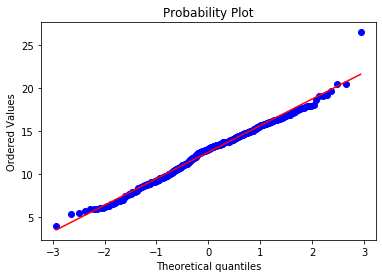

In [72]:
res=st.probplot(st.boxcox(y)[0],plot=plt)

In [71]:
st.boxcox(y)[0]

array([12.75898214, 13.70425155, 14.77548837, 16.26821174, 13.89700277,
       11.41089743, 13.29170067, 14.65201191,  7.865967  ,  8.82230758,
       13.53149538, 16.89816869, 13.07136265,  9.29194714, 11.93315469,
       15.42346475, 19.07411398, 12.64627339, 13.72575115, 14.85744892,
       10.72442762, 15.64228573,  9.50817038, 14.89832335, 12.96033096,
       10.1401257 , 16.5373171 , 11.76851493, 14.71383104, 16.70886112,
        8.82230758,  9.61519811, 11.90971977, 15.18250655, 16.32611262,
       10.21746709,  9.04509605,  9.69500811, 14.85744892, 14.54861645,
        6.96681902,  7.68489244, 12.02661514, 11.8862567 , 16.09372323,
       12.84871019, 13.6611895 , 17.53202896,  6.13591795,  6.06680248,
       14.13035744,  8.42429143, 10.1401257 , 12.98258408, 15.66208312,
        6.23880209, 13.6396269 , 16.01578914,  8.96193076, 13.74722989,
        8.59618209, 17.84355263, 10.32004824, 16.30682674,  9.69500811,
       14.15145259, 15.46339486, 16.65180396, 12.37321835, 13.66

In [ ]:
"Cartodb Positron"'Stamen Toner'

In [ ]:
mm=folium.Map(location=台北車站,zoom_start=11,tiles="Cartodb Positron")
dis=1
if dis==1:
    folium.GeoJson(
        gdf_boundry,
        style_function = lambda x: {
            'color': '#642100',
            'weight': 4,
            'fillOpacity': 0.2
        },
        name='行政區邊界').add_to(mm)
    
    
for i in range(TLW.shape[0]):
    if TLW.type[i]==0:
        iframe = IFrame(html=heading3(utf2asc(TLW.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[TLW.lat[i], TLW.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='orange')).add_to(mm)
    '''
    elif TLW.type[i]==2:
        iframe = IFrame(html=heading3(utf2asc(TLW.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[TLW.lat[i], TLW.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='pink')).add_to(mm)
    else:  
        iframe = IFrame(html=heading3(utf2asc(TLW.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[TLW.lat[i], TLW.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='gray')).add_to(mm)
                                        '''


df03=df02.loc[(df02.site.isin(['1A01'])),:].reset_index(drop=True)
num=df03.shape[0]
lat=np.array(df03["lat"][0:num])
lon=np.array(df03["lon"][0:num])
data1=[[lat[i],lon[i],1] for i in range(num)]
fg1=folium.FeatureGroup(name='南崁店(點)', show=True)
for i in range(num):
    folium.Circle(location=[data1[i][0],data1[i][1]],
    color='#EA0000', # Circle 顏色
    radius=25, # Circle 寬度
    fill=True, # 填滿中間區域
    fill_opacity=0.7 # 設定透明度
    ).add_to(fg1)
mm.add_child(fg1)
#HeatMap(data1,radius=8,name='南崁店(熱力圖)').add_to(mm)


df03=df02.loc[(df02.site.isin(['1A07'])),:].reset_index(drop=True)
num=df03.shape[0]
lat=np.array(df03["lat"][0:num])
lon=np.array(df03["lon"][0:num])
data1=[[lat[i],lon[i],1] for i in range(num)]
fg2=folium.FeatureGroup(name='內湖店(點)', show=True)
for i in range(num):
    folium.Circle(location=[data1[i][0],data1[i][1]],
    color='#0066CC', # Circle 顏色
    radius=25, # Circle 寬度
    fill=True, # 填滿中間區域
    fill_opacity=0.7 # 設定透明度
    ).add_to(fg2)
mm.add_child(fg2)
#HeatMap(data1,radius=8,name='內湖店(熱力圖)').add_to(mm)

'''
df03=df02.loc[(df02.site.isin(['1A16'])),:].reset_index(drop=True)
num=df03.shape[0]
lat=np.array(df03["lat"][0:num])
lon=np.array(df03["lon"][0:num])
data1=[[lat[i],lon[i],1] for i in range(num)]
fg3=folium.FeatureGroup(name='新竹店(點)', show=True)
for i in range(num):
    folium.Circle(location=[data1[i][0],data1[i][1]],
    color='#00A600', # Circle 顏色
    radius=25, # Circle 寬度
    fill=True, # 填滿中間區域
    fill_opacity=0.7 # 設定透明度
    ).add_to(fg3)
mm.add_child(fg3)
#HeatMap(data1,radius=8,name='新竹店(熱力圖)').add_to(mm)
'''

df03=df02.loc[(df02.site.isin(['1A09'])),:].reset_index(drop=True)
num=df03.shape[0]
lat=np.array(df03["lat"][0:num])
lon=np.array(df03["lon"][0:num])
data1=[[lat[i],lon[i],1] for i in range(num)]
fg4=folium.FeatureGroup(name='士林店(點)', show=True)
for i in range(num):
    folium.Circle(location=[data1[i][0],data1[i][1]],
    color='#00A600', # Circle 顏色
    radius=25, # Circle 寬度
    fill=True, # 填滿中間區域
    fill_opacity=0.7 # 設定透明度
    ).add_to(fg4)
mm.add_child(fg4)
#HeatMap(data1,radius=8,name='士林店(熱力圖)').add_to(mm)


fg5=folium.FeatureGroup(name='南崁店(半徑)', show=True)
folium.Circle(location=[TLW[TLW.name.isin(['1A01南崁店'])].lat.values[0],TLW[TLW.name.isin(['1A01南崁店'])].lon.values[0]],
    color='#FFFF37', # Circle 顏色
    radius=9000, # Circle 寬度
    fill=False, # 填滿中間區域
    weight = 6,
    dash_array='10',
    fill_opacity=1 # 設定透明度
).add_to(fg5)
mm.add_child(fg5)

fg6=folium.FeatureGroup(name='內湖店(半徑)', show=True)
folium.Circle(location=[TLW[TLW.name.isin(['1A07內湖店'])].lat.values[0],TLW[TLW.name.isin(['1A07內湖店'])].lon.values[0]],
    color='#FFFF37', # Circle 顏色
    radius=7000, # Circle 寬度
    fill=False, # 填滿中間區域
    weight = 6,
    dash_array='10',
    fill_opacity=1 # 設定透明度
).add_to(fg6)
mm.add_child(fg6)

fg7=folium.FeatureGroup(name='士林店(半徑)', show=True)
folium.Circle(location=[TLW[TLW.name.isin(['1A09士林店'])].lat.values[0],TLW[TLW.name.isin(['1A09士林店'])].lon.values[0]],
    color='#FFFF37', # Circle 顏色
    radius=7000, # Circle 寬度
    fill=False, # 填滿中間區域
    weight = 6,
    dash_array='10',
    fill_opacity=1 # 設定透明度
).add_to(fg7)
mm.add_child(fg7)

fg8=folium.FeatureGroup(name='中和店(半徑)', show=True)
folium.Circle(location=[TLW[TLW.name.isin(['1A17中和店'])].lat.values[0],TLW[TLW.name.isin(['1A17中和店'])].lon.values[0]],
    color='#FF0080', # Circle 顏色
    radius=7000, # Circle 寬度
    fill=False, # 填滿中間區域
    weight = 6,
    dash_array='10',
    fill_opacity=1 # 設定透明度
).add_to(fg8)
mm.add_child(fg8)

folium.LayerControl().add_to(mm)


In [ ]:
def get_little():
    lon=float(input('請輸入店點經度 : '))
    lat=float(input('請輸入店點緯度 : '))
    geom=[Point(lon,lat)]
    crs = {'init': 'epsg:4326'}
    gdf_little = gpd.GeoDataFrame(pd.DataFrame({'Name':['TLW_little']}), crs=crs, geometry=geom)
    return gdf_little

def trans(gdf):
    gdf.crs = {'init' :'epsg:4326'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs(epsg=3826)
    return gdf

In [ ]:
gdf_little=get_little()
gdf_little=trans(gdf_little)

gdf_little_buffer=gdf_little.copy()
radius=float(input('請輸入半徑(公尺) : '))
gdf_little_buffer['geometry']=gdf_little_buffer.buffer(radius)

In [ ]:
for s in site2:
    folium.GeoJson(
        gdf_final[gdf_final['縣市']==s][['geometry','縣市','行政區','村里','平均數','中位數','標準差']],
        name='所得', 
        style_function=style_function,
        highlight_function=lambda x: {'weight':3, 
                                        'color':site_colors.get(x['properties']['縣市']),
                                        'fillOpacity':0.75},
        smooth_factor=2.0,
        tooltip=folium.features.GeoJsonTooltip(fields=['縣市','行政區','村里','平均數','中位數'],
                                                  aliases=['縣市','行政區','村里','平均數','中位數'], 
                                                  labels=True, 
                                                  sticky=True,
                                                  toLocaleString=True
                                                 )
    ).add_to(mm)